In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import sys
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

In [3]:
california_ozone = pd.read_csv("../dataset/cal_o3.csv", index_col = None)

In [4]:
cadf = california_ozone
cadf = cadf[cadf['Time Local'] <= '18:00']
cadf = cadf[cadf['Time Local'] >= '10:00']

In [5]:
county_codes = cadf['County Code'].values
site_code = cadf['Site Num'].values
site_id = [str(county_codes[i]) + str(site_code[i]) for i in range(len(county_codes))]

In [6]:
cadf['ID'] = site_id

In [7]:
cadf.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change', 'ID'],
      dtype='object')

In [8]:
mask = cadf.groupby(['ID', 'Date Local'])['Sample Measurement'].count() >= 8

In [9]:
cadf = cadf.groupby(['ID', 'Date Local']).mean()[mask]

In [10]:
cadf.reset_index(inplace=True)

In [11]:
cadf = cadf[['ID', 'Date Local', 'Latitude', 'Longitude', 'Sample Measurement']]

In [12]:
m1 = cadf['Date Local'] >= '1990-05-01'
m2 = cadf['Date Local'] <= '1990-09-30'
mf = m1 & m2
cadf = cadf[mf]

In [13]:
m4 = cadf.groupby('ID').count()>=115

In [14]:
cadf.groupby('ID').median()

,Latitude,Longitude,Sample Measurement
ID,,,
1012,38.848232,-121.515236,0.045556
1013,39.138773,-121.618549,0.042222
1033,40.169321,-122.254441,0.057778
1072002,36.332179,-119.291228,0.066667
1075,36.493557,-118.829543,0.073389
...,...,...,...
974001,38.295747,-122.457758,0.036667
991003,37.522712,-120.867707,0.054444
991004,37.371047,-121.133265,0.051111


In [15]:
cadf = cadf.groupby('ID').mean()[m4]

In [16]:
cadf.dropna(inplace = True)

In [17]:
ca_df = cadf.copy()

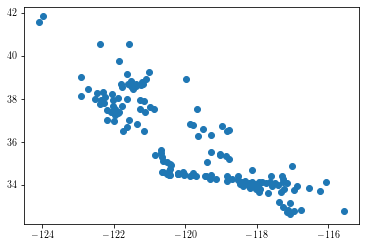

In [18]:
plt.scatter(cadf['Longitude'], cadf['Latitude'])

## Need to do leave-one-out cross validation in Southern California.
## Southern California is Latitude <=34.81

In [19]:
socaldf = cadf[cadf['Latitude'] <= 34.81]

In [20]:
socaldf.shape

(73, 3)

In [21]:
X = socaldf[['Longitude', 'Latitude']].values
y = socaldf[['Sample Measurement']]*1000
y = y.values

In [22]:
from polire.interpolate import Kriging, SpatialAverage
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor

In [24]:
kriging_predictions = []
knn_predictions = []
spatial_predictions = []
for ix in range(X.shape[0]):
    X_train = np.vstack((X[:ix], X[ix+1:]))
    y_train = np.vstack((y[:ix], y[ix+1:]))
    X_test = X[ix].reshape(1, 2)
    y_test = y[ix].reshape(-1, 1)   
    krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
    krig.fit(X_train, y_train)
    kriging_predictions.append(krig.predict(X_test).reshape(1, ))
    knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
    knn.fit(X_train, y_train)
    knn_predictions.append(knn.predict(X_test).reshape(1, ))
    spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
    spatial.fit(X_train, y_train)
    spatial_predictions.append(spatial.predict(X_test).reshape(1, ))

In [25]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## Kriging

In [26]:
linear = LinearRegression()
linear.fit(kriging_predictions, y)
linear.coef_, r2_score(y, linear.predict(kriging_predictions))

(array([[1.06613511]]), 0.7804042062328492)

## Spatial Averaging

In [27]:
spatial_predictions = np.array(spatial_predictions)
mask = ~np.isnan(spatial_predictions)
y_spt = y[mask]
spatial_predictions_1 = spatial_predictions[mask]
linear = LinearRegression()
linear.fit(spatial_predictions_1.reshape(-1, 1), y_spt)
linear.coef_, r2_score(y_spt, linear.predict(spatial_predictions_1.reshape(-1, 1)))

(array([0.96384508]), 0.7832038030560715)

## Nearest Neighbor

In [28]:
linear = LinearRegression()
linear.fit(knn_predictions, y)
linear.coef_, r2_score(y, linear.predict(knn_predictions))

(array([[0.80732258]]), 0.6783862462470492)